# PAW Model Inference Demo

Simple example showing how to:
1. Load a seismic waveform from ObsPy
2. Preprocess it (filter, resample, normalize)
3. Run PAW model inference
4. Visualize results

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from obspy import read

# PAW library
from pawlib import PAW
from pawlib import normalize_waveform

In [2]:
# Load ObsPy example waveform
stream = read('https://examples.obspy.org/COP.BHZ.DK.2009.050')
trace = stream[0]

print(f"Loaded: {trace.stats.network}.{trace.stats.station}.{trace.stats.channel}")
print(f"Sampling rate: {trace.stats.sampling_rate} Hz")
print(f"Duration: {trace.stats.endtime - trace.stats.starttime:.0f} seconds")

# Define window parameters
onset_time = 200.0
window_duration = 5.0
padding = 2.0

# Extract window FIRST (with padding)
window_start = onset_time - padding
window_end = onset_time + window_duration + padding

trace_window = trace.slice(trace.stats.starttime + window_start, 
                           trace.stats.starttime + window_end)
trace_window = trace_window.copy()

# Preprocess using ObsPy methods
trace_window.detrend('linear')
trace_window.filter('bandpass', freqmin=1.0, freqmax=15.0)
trace_window.resample(40.0)

# Trim padding after preprocessing
samples_per_second = 40.0
padding_samples = int(padding * samples_per_second)
total_samples = int(window_duration * samples_per_second)

# Extract numpy array and normalize
waveform_raw = trace_window.data[padding_samples:padding_samples + total_samples]
waveform_raw = waveform_raw.reshape(1, -1, 1).astype(np.float32)
waveform_raw = normalize_waveform(waveform_raw)  # Now it's a numpy array

print(f"\nExtracted window: {onset_time:.1f}s to {onset_time + window_duration:.1f}s")
print(f"Raw waveform shape: {waveform_raw.shape}")
print(f"Expected shape: (1, {int(window_duration * samples_per_second)}, 1)")

Loaded: DK.COP.BHZ
Sampling rate: 20.0 Hz
Duration: 86400 seconds

Extracted window: 200.0s to 205.0s
Raw waveform shape: (1, 200, 1)
Expected shape: (1, 200, 1)


/home/ariana/miniforge3/envs/test-pawlib/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (15.0) of bandpass is at or above Nyquist (10.0). Applying a high-pass instead.
  warnings.warn(msg)


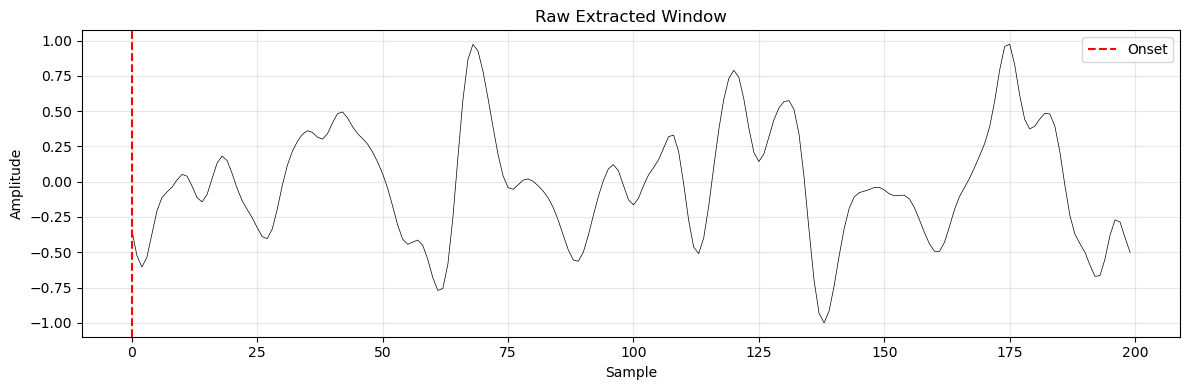

In [3]:
# Visualize extracted window (optional)
plt.figure(figsize=(12, 4))
plt.plot(waveform_raw[0, :, 0], 'k-', linewidth=0.5)
plt.axvline(int(0 * trace.stats.sampling_rate), color='r', linestyle='--', label='Onset')
plt.title('Raw Extracted Window')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [4]:
# Add padding
waveform = np.pad(waveform_raw, ((0, 0), (20, 20), (0, 0)), mode='constant')
waveform.shape

(1, 240, 1)

# Load model and run inference
from pawlib import extract_windows_from_prediction
import torch

model = PAW.from_pretrained('hf://suroRitch/pawlib-pretrained/paw_corrected.pt')
prediction = model.predict(waveform[:, 20:-20, :])
pred_windows = extract_windows_from_prediction(prediction)

print(f"✓ Prediction shape: {prediction.shape}")
print(f"✓ Detected windows: {pred_windows.shape}")

In [6]:
# Use the new predict_windows method to get both windows and raw predictions
model = PAW.from_pretrained('hf://suroRitch/pawlib-pretrained/paw_corrected.pt')

# Get both refined windows AND raw model predictions
refined_windows, predictions = model.predict_windows(
    waveform[:, 20:-20, :], 
    debug_half_cycle=True,
    return_predictions=True
)

window_start = refined_windows[0, 0].item() / 40.0
window_end = refined_windows[0, 1].item() / 40.0

print(f"Detected window: [{window_start:.3f}, {window_end:.3f}] seconds")
print(f"Raw predictions shape: {predictions.shape}")
print(f"Predictions range: [{predictions.min():.3f}, {predictions.max():.3f}]")

✓ Downloaded to: /home/ariana/.cache/huggingface/hub/models--suroRitch--pawlib-pretrained/snapshots/b609bb74d3c30b17d6b8f3c34fac2c3a95c0c484/paw_corrected.pt
Model loaded from hf://suroRitch/pawlib-pretrained/paw_corrected.pt
Metadata: {'padding': 20, 'freq': 0.025}

=== Half-Cycle Debug for Window 0 ===
Original window: [80, 88]
Bounded window: [80, 88]
Window length: 9 samples (0.225s)
Window signal: ['-0.679', '-0.771', '-0.756', '-0.586', '-0.257', '0.169', '0.579', '0.865', '0.974']

Found local extrema:
  0: position 0, value -0.679, type boundary
  1: position 1, value -0.771, type min
  2: position 8, value 0.974, type boundary

Generated subwindows:
  0: [0, 1] (-0.679 → -0.771) amp=0.092, dur=2
  1: [0, 8] (-0.679 → 0.974) amp=1.653, dur=9
  2: [1, 8] (-0.771 → 0.974) amp=1.745, dur=8

Best subwindow selected:
  Position: [1, 8]
  Values: -0.771 → 0.974
  Amplitude: 1.745
  Duration: 8 samples (0.200s)
  Absolute indices: [81, 88]

Validation:
  Original: 9 samples (0.225s)
 

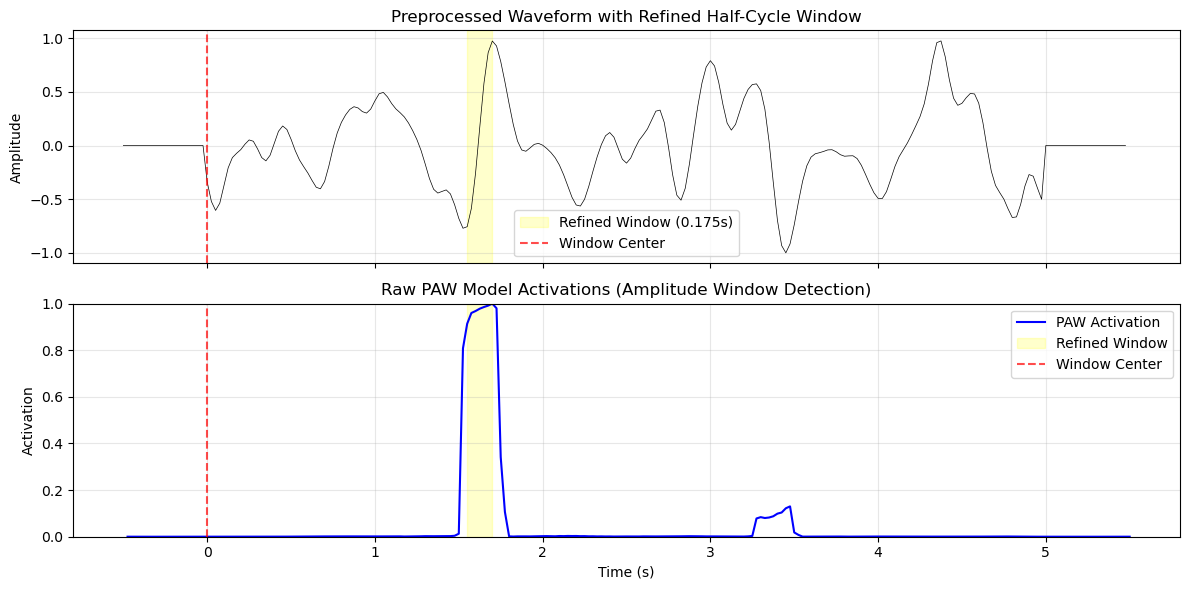

In [7]:
# Visualization with both raw predictions and refined windows
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

time = (np.arange(waveform.shape[1]) / 40.0) - 0.5
onset_time = 0
window_start_plot = window_start - 0.5 + (1/40)
window_end_plot = window_end - 0.5

# Plot waveform with extracted window
ax1.plot(time, waveform[0, :, 0], 'k-', linewidth=0.5)
ax1.axvspan(window_start_plot, window_end_plot, alpha=0.2, color='yellow', 
            label=f'Refined Window ({window_end-window_start:.3f}s)', zorder=0)
ax1.axvline(onset_time, color='r', linestyle='--', label='Window Center', alpha=0.7)
ax1.set_ylabel('Amplitude')
ax1.set_title('Preprocessed Waveform with Refined Half-Cycle Window')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot raw model predictions (activation function)
time_pred = (np.arange(predictions.shape[2]) / 40.0) - 0.5 + (1/40)
ax2.plot(time_pred, predictions[0, 0, :], 'b-', linewidth=1.5, label='PAW Activation')
ax2.axvspan(window_start_plot, window_end_plot, alpha=0.2, color='yellow', 
            label='Refined Window', zorder=0)
ax2.axvline(onset_time, color='r', linestyle='--', label='Window Center', alpha=0.7)
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Activation')
ax2.set_title('Raw PAW Model Activations (Amplitude Window Detection)')
ax2.set_ylim([0, 1])
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()